<a href="https://colab.research.google.com/github/JuanM-GG/modelos-tesis/blob/main/optimizacion_tasa_dilucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Optimización de la tasa de dilución $D$

Autor: Juan Manuel Gutiérrez García 

Fecha: enero 2021

# Resumen 
En el presente cuaderno llevamos a cabo la optimización de la tasa de dilución. El problema consiste en encontrar el valor de la tasa de dilución, $D$, que permita generar la mayor producción de biomasa, $\dot{m}_x$, en condiciones estacionarias. Para realizar esta optimización se consideran los parámetros cinéticos de las levaduras *Isstchenkia terrícola*, *Kluyveromyces marxianus*, *Pichia kluyveri*, *Zygosaccharomyces bailii* y *Zigosaccharomyces rouxi* obtenidos anteriormente mediante optimización paramétrica. 

# Optimización de la producción de biomasa 

Ahora podríamos preguntarnos sobre cuál es el valor del parámetro $D$ que nos permite generar una mayor cantidad de biomasa. Consideremos, por ejemplo, una valor de $D$ muy bajo. Como vimos en el diagrama de bifurcación, un valor bajo da lugar a un valor de concentración de biomasa en el equilibrio, $\bar{x}$, alto, sin embargo, al ser el flujo en la salida del biorreactor demasiado bajo, el flujo de biomasa en la salida también lo será. Por otro lado, si el valor de $D$ es muy alto, tendremos un mayor flujo de biomasa en la salida pero de acuerdo con el diagrama de bifurcación, el valor de la concentración de biomasa será muy bajo y corremos el riesgo de llevar al sistema al punto de equilibrio trivial $ss_1$ donde no existe biomasa. 

Para resolver este problema de optimización empezamos por definir la función que nos interesa optimizar, en este caso, esta función es la cantidad de biomasa que se obtiene del biorreactor

$$G(D) = D \bar{x}$$

Donde $\bar{x}$ es la concetración de biomasa en el equilibrio. 

Considerando 

$$\bar{x} = Y_{xs} (s_f - \bar{s}) \hspace{1cm} y \hspace{1cm} \bar{s} = \frac{D k_s}{\mu_{max} - D}$$

Tenemos 

$$G(D) = D Y_{xs} (s_f - \frac{D k_s}{\mu_{max} - D})$$

In [63]:
# cargar librerías
library(ggplot2)

In [64]:
p <- c(mu_max = 1.2, ks = 180, Yxs = 0.1, sf = 50, D = 0.01)

In [65]:
#@title establecer función objetivo 
# aquí x representa la variable a optimizar, osea D 
gain1 <- function(x, p) {
  with(as.list(p), {

    G = x*Yxs*(sf - x*ks/(mu_max - x))

    return(G)

  })
}

In [66]:
# valores de D a evaluar
x <- seq(0,0.2,len=100)

In [67]:
# evaluar función G
Gain <- gain1(x,p)
# guardar resultados 
out <- data.frame(D = x, Gain = Gain)

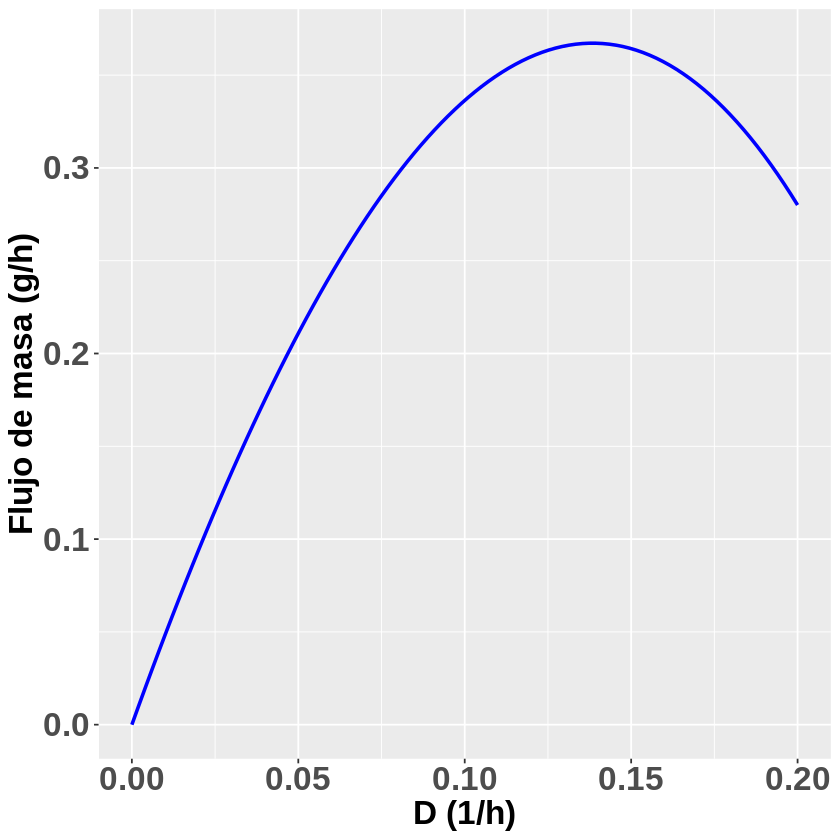

In [68]:
#@title mostrar resultados 
ggplot(out, aes(x = D, y = Gain)) +
  geom_line(lty = 1, lwd = 1, color = "blue") +
  ylab("Flujo de masa (g/h)") +
  xlab("D (1/h)") +
  theme(
        plot.title = element_text(size=22),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

In [69]:
#@title función para obtener D_opt para un conjunto de parametros 
D_opt <- function(p) {
    with(as.list(p), {

        D_opt = mu_max*sf/(2*ks)

        return(D_opt)
    })
}

Aun así, mostramos como encontrar este valor usando la función `optimise()`

In [70]:
# función auxiliar para realizar la optimización
gain2 <- function(x, p) {
        
        G = gain1(p = p, x = x)
        # el menos es porque la función optimise() minimiza
        return(-G)
}

In [71]:
# encontrar el máximo 
sol <- optimise(f = gain2, lower = 0,upper = 0.5, p = p)
# resultado analítico
cat("D_opt de forma analítica:", D_opt(p), "(1/h) \n")
# resultado numérico 
cat("D_opt:", sol$minimum, "(1/h) \n")
cat("mx_max: ", - sol$objective, "g/h")

D_opt de forma analítica: 0.1666667 (1/h) 
D_opt: 0.1384012 (1/h) 
mx_max:  0.3672241 g/h

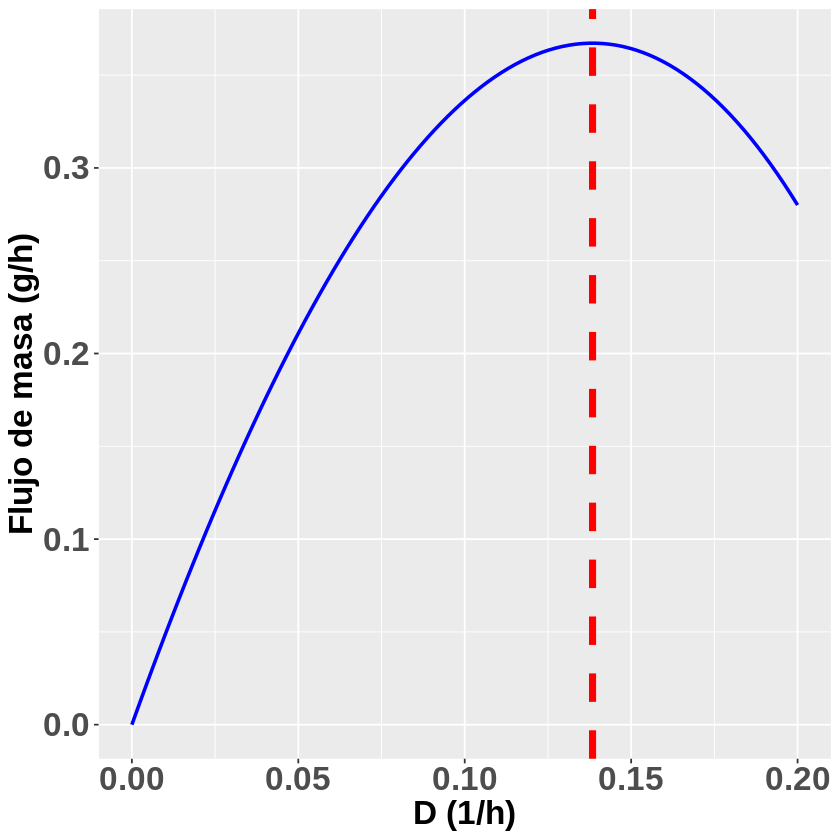

In [72]:
# mostrar resultados 
ggplot(out, aes(x = D, y = Gain)) +
  geom_line(lty = 1, lwd = 1, color = "blue") +
  geom_vline(xintercept = sol$minimum, color = "red", lwd = 2, lty = 2) +
  ylab("Flujo de masa (g/h)") +
  xlab("D (1/h)") +
  theme(
        plot.title = element_text(size=22),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

### Valor superior para $D$

In [73]:
# función para calcular D*
D_bif <- function(p) {
  with(as.list(p), {

    D = mu_max*sf/(ks + sf)

    return(D)
  })
}

# Optimización con parámetros de *Isstchenkia terrícola*

Debemos proponer un valor para el parámetros $s_f$. Establezcamos $s_f = 50\ g/L$

### Graficar $G(D)$

In [74]:
# parámetros óptimos de Isstchenkia terrícola
p_it <- c(mu_max = 1.4536067, ks = 284.3997206, Yxs = 0.1092001, Ypx = 7.0414839, sf = 50)

In [75]:
# valor superior para D
D_bif(p_it)

[1] 0.2173457

In [76]:
# evaluar función G
Gain <- gain1(x,p_it)
# guardar resultados 
out_it <- data.frame(D = x, Gain = Gain)

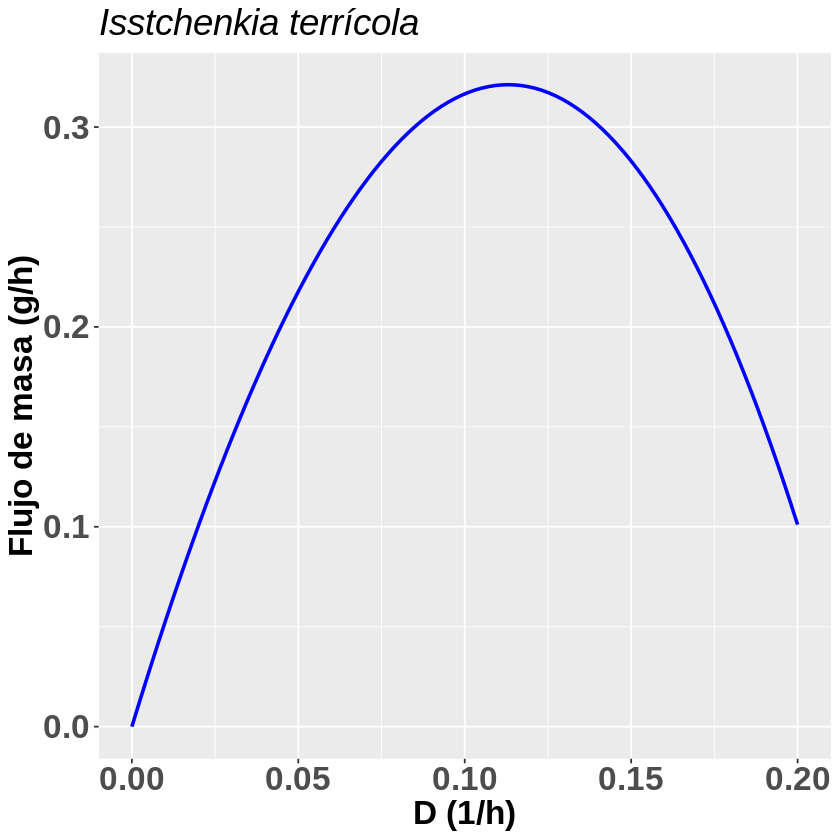

In [77]:
# mostrar resultados 
ggplot(out_it, aes(x = D, y = Gain)) +
  geom_line(lty = 1, lwd = 1, color = "blue") +
  ylab("Flujo de masa (g/h)") +
  xlab("D (1/h)") +
  labs(title = "Isstchenkia terrícola") +
  theme(
        plot.title = element_text(size=22, face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

### Realizar optimización 

In [78]:
# encontrar el máximo
sol_it <- optimise(f = gain2, lower = 0,upper = 0.5, p = p_it)
# resultado analítico 
cat("D_opt de forma analítica:", D_opt(p_it), "(1/h) \n")
# resultado numérico
cat("D_opt:", sol_it$minimum, "(1/h) \n")
cat("mx_max: ", - sol_it$objective, "g/h")

D_opt de forma analítica: 0.1277785 (1/h) 
D_opt: 0.1130833 (1/h) 
mx_max:  0.3211742 g/h

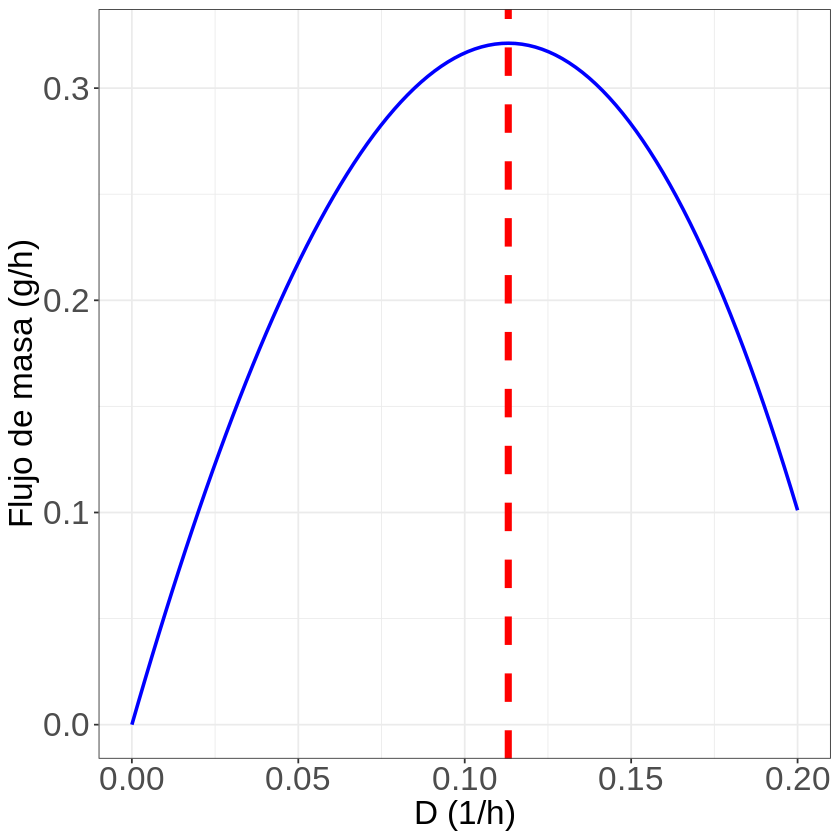

In [79]:
# mostrar resultados 
ggplot(out_it, aes(x = D, y = Gain)) +
  geom_line(lty = 1, lwd = 1, color = "blue") +
  geom_vline(xintercept = sol_it$minimum, color = "red", lty = 2, lwd = 2) +
  ylab("Flujo de masa (g/h)") +
  xlab("D (1/h)") +
  #labs(title = "Isstchenkia terrícola") +
  theme_bw() + 
  theme(
        plot.title = element_text(size=22, face = "italic"),
        axis.text=element_text(size=20),
        axis.title=element_text(size=20),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

# Optimización con parámetros de *Kluyveromyces marxianus*

### Graficar $G(D)$

In [80]:
# parámetros óptimo para Kluyveromyces marxianus
p_km <- c(mu_max = 1.0110607, ks = 353.3425303, Yxs = 0.1301708, Ypx = 4.9448320, sf = 60)      

In [81]:
D_bif(p_km)

[1] 0.1467636

In [82]:
# evaluar función G
Gain <- gain1(x,p_km)
# guardar resultados 
out_km <- data.frame(D = x, Gain = Gain)

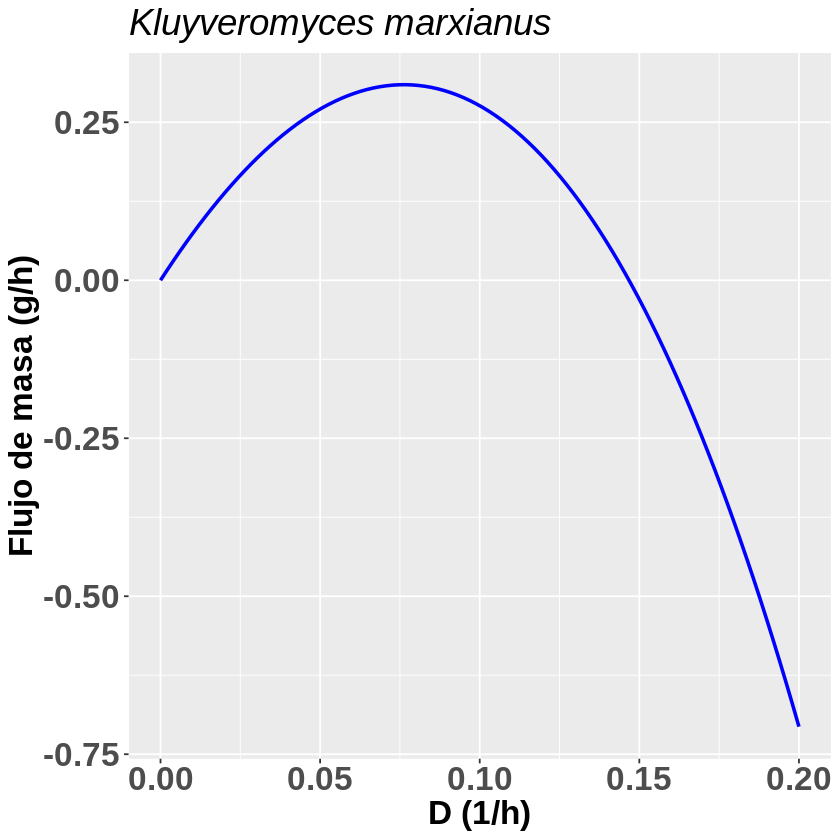

In [83]:
# mostrar resultados 
ggplot(out_km, aes(x = D, y = Gain)) +
  geom_line(lty = 1, lwd = 1, color = "blue") +
  ylab("Flujo de masa (g/h)") +
  xlab("D (1/h)") +
  labs(title = "Kluyveromyces marxianus") +
  theme(
        plot.title = element_text(size=22, face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

### Realizar optimización 

In [84]:
# encontrar el máximo
sol_km <- optimise(f = gain2, lower = 0,upper = 0.5,p = p_km)
# resultado analítico
cat("D_opt de forma analística:", D_opt(p_km), "(1/h) \n")
# resultado numérico
cat("D_opt:", sol_km$minimum, "(1/h) \n")
cat("mx_max: ", - sol_km$objective, "g/h")

D_opt de forma analística: 0.08584254 (1/h) 
D_opt: 0.07625919 (1/h) 
mx_max:  0.3094659 g/h

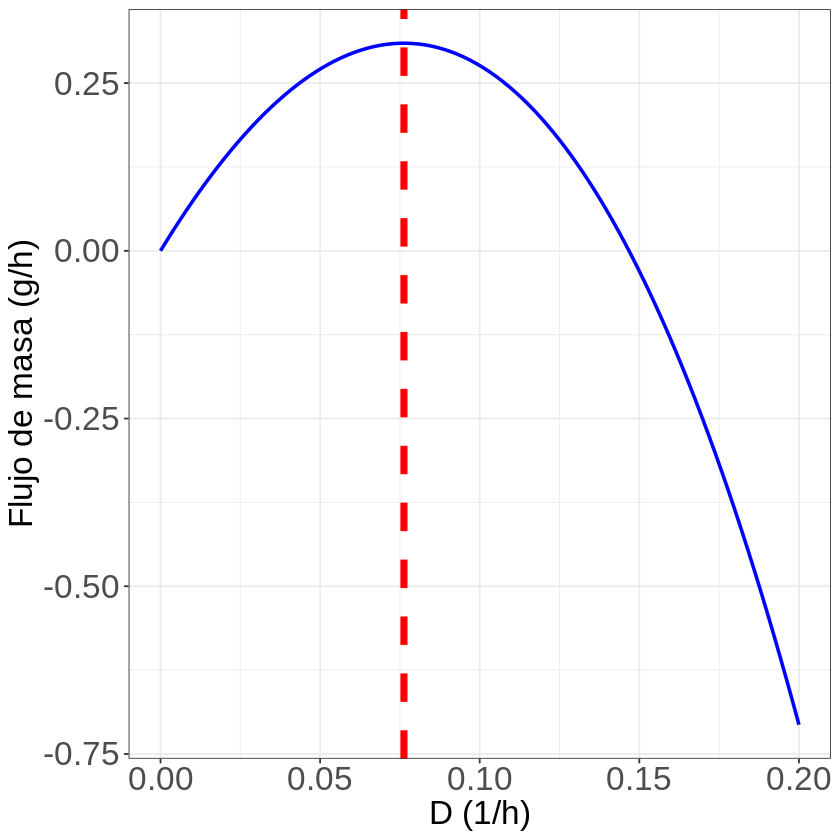

In [85]:
# mostrar resultados 
ggplot(out_km, aes(x = D, y = Gain)) +
  geom_line(lty = 1, lwd = 1, color = "blue") +
  geom_vline(xintercept = sol_km$minimum, color = "red", lty = 2, lwd = 2) +
  ylab("Flujo de masa (g/h)") +
  xlab("D (1/h)") +
  #labs(title = "Kluyveromyces marxianus") +
  theme_bw() +
  theme(
        plot.title = element_text(size=22, face = "italic"),
        axis.text=element_text(size=20),
        axis.title=element_text(size=20),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

# Optimización con parámetros de *Pichia kluyveri*

### Graficar $G(D)$

In [86]:
# parámetros óptimos de Pichia kluyveri
p_pk <- c(mu_max = 0.6588448, ks = 366.8216124, Yxs = 0.1032014, Ypx = 3.8650679, sf = 50)  

In [87]:
D_bif(p_pk)

[1] 0.07903199

In [88]:
# evaluar función G
Gain <- gain1(x,p_pk)
# guardar resultados 
out_pk <- data.frame(D = x, Gain = Gain)

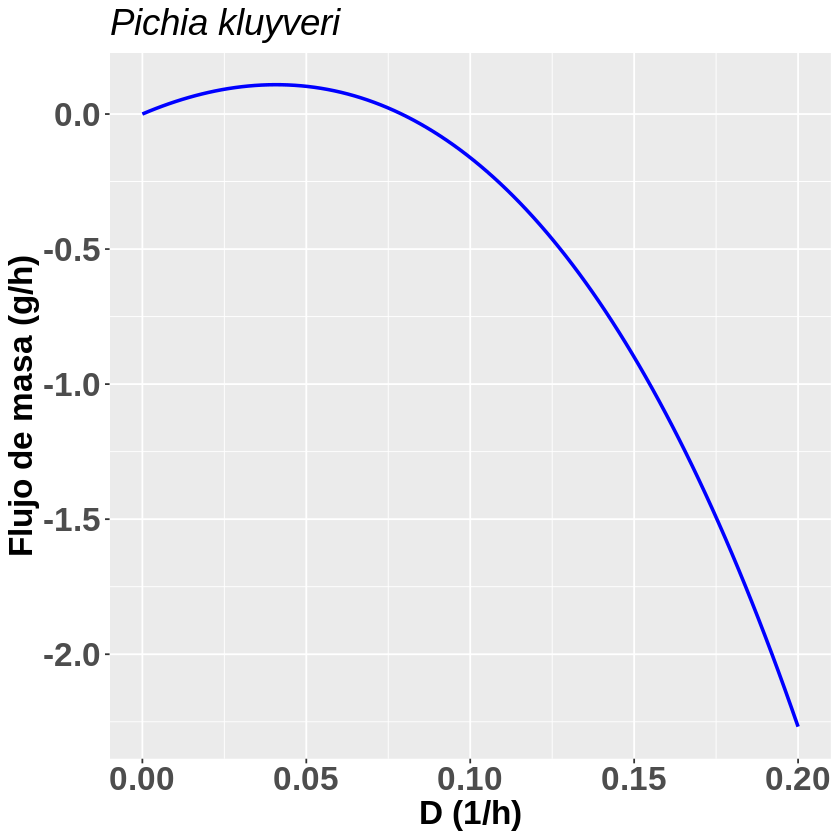

In [89]:
# mostrar resultados 
ggplot(out_pk, aes(x = D, y = Gain)) +
  geom_line(lty = 1, lwd = 1, color = "blue") +
  ylab("Flujo de masa (g/h)") +
  xlab("D (1/h)") +
  labs(title = "Pichia kluyveri") +
  theme(
        plot.title = element_text(size=22, face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

### Realizar optimización 

In [90]:
# encontrar el máximo
sol_pk <- optimise(f = gain2, lower = 0,upper = 0.08, p = p_pk)
# resultado analítico
cat("D_opt de forma analística:", D_opt(p_pk), "(1/h) \n")
# resultado numérico
cat("D_opt:", sol_pk$minimum, "(1/h) \n")
cat("mx_max: ", - sol_pk$objective, "g/h")

D_opt de forma analística: 0.04490226 (1/h) 
D_opt: 0.04077689 (1/h) 
mx_max:  0.1085683 g/h

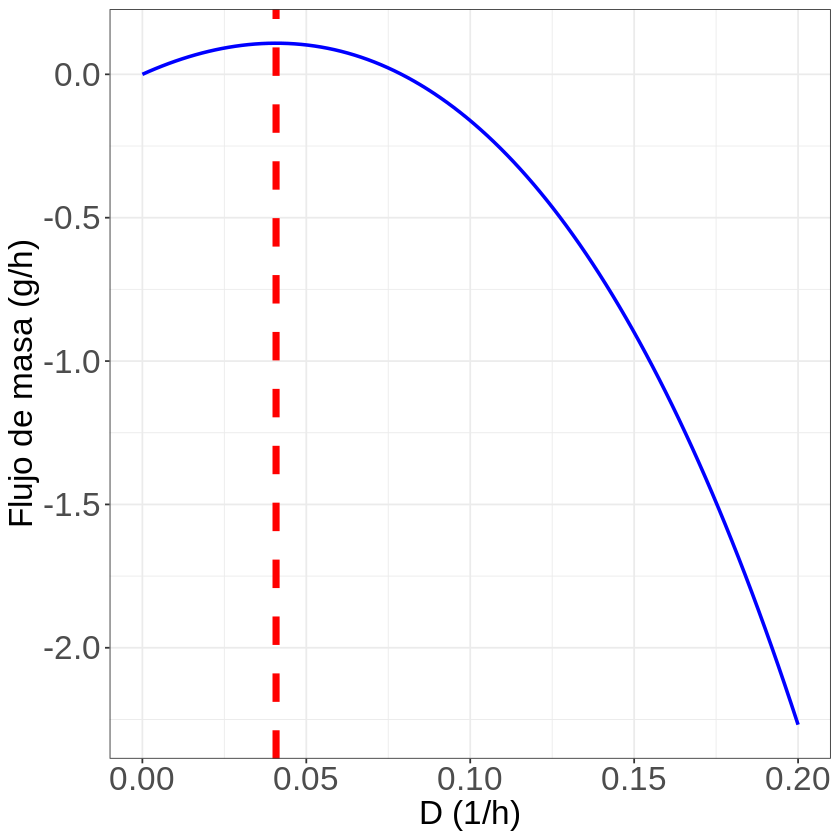

In [91]:
# mostrar resultados 
ggplot(out_pk, aes(x = D, y = Gain)) +
  geom_line(lty = 1, lwd = 1, color = "blue") +
  geom_vline(xintercept = sol_pk$minimum, color = "red", lty = 2, lwd = 2) +
  ylab("Flujo de masa (g/h)") +
  xlab("D (1/h)") +
  #labs(title = "Pichia kluyveri") +
  theme_bw() +
  theme(
        plot.title = element_text(size=22, face = "italic"),
        axis.text=element_text(size=20),
        axis.title=element_text(size=20),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

# Optimización con parámetros de *Zygosaccharomyces bailii*

### Graficar $G(D)$

In [92]:
# parámetros óptimos de Zygosaccharomyces bailii
p_zb <- c(mu_max = 1.1682471, ks = 300.1541664, Yxs = 0.1171282, Ypx = 4.9301197, sf = 50)  

In [93]:
D_bif(p_zb)

[1] 0.166819

In [94]:
# evaluar función G
Gain <- gain1(x,p_zb)
# guardar resultados 
out_zb <- data.frame(D = x, Gain = Gain)

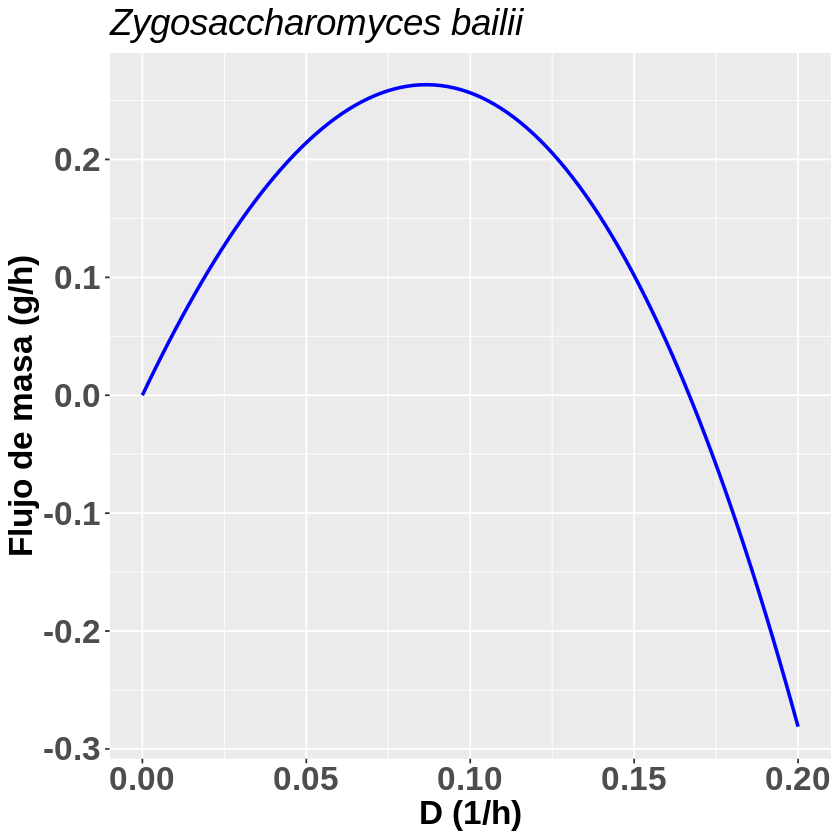

In [95]:
# mostrar resultados 
ggplot(out_zb, aes(x = D, y = Gain)) +
  geom_line(lty = 1, lwd = 1, color = "blue") +
  ylab("Flujo de masa (g/h)") +
  xlab("D (1/h)") +
  labs(title = "Zygosaccharomyces bailii") +
  theme(
        plot.title = element_text(size=22, face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

### Realizar optimización 

In [96]:
# encontrar el máximo
sol_zb <- optimise(f = gain2, lower = 0,upper = 0.5,p = p_zb)
# solución analítica
cat("D_opt de forma analística:", D_opt(p_zb), "(1/h) \n")
# solución numérica
cat("D_opt:", sol_zb$minimum, "(1/h) \n")
cat("mx_max: ", - sol_zb$objective, "g/h")

D_opt de forma analística: 0.09730392 (1/h) 
D_opt: 0.08664013 (1/h) 
mx_max:  0.2634087 g/h

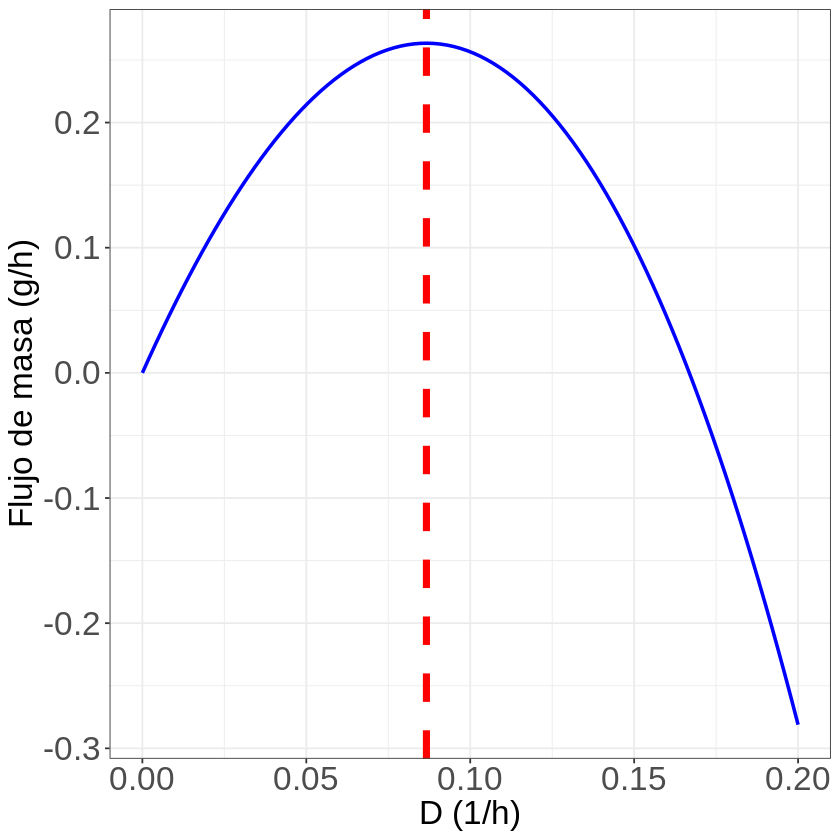

In [97]:
# mostrar resultados 
ggplot(out_zb, aes(x = D, y = Gain)) +
  geom_line(lty = 1, lwd = 1, color = "blue") +
  geom_vline(xintercept = sol_zb$minimum, color = "red", lty = 2, lwd = 2) +
  ylab("Flujo de masa (g/h)") +
  xlab("D (1/h)") +
  #labs(title = "Zygosaccharomyces bailii") +
  theme_bw() +
  theme(
        plot.title = element_text(size=22, face = "italic"),
        axis.text=element_text(size=20),
        axis.title=element_text(size=20),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

# Optimización con parámetros de *Zigosaccharomyces rouxi*

### Graficar $G(D)$

In [98]:
# parámetros óptimos de Zygosaccharomyces bailii
p_zr <- c(mu_max = 0.5003527, ks = 250.9052285, Yxs = 0.1950366, Ypx = 3.1550382, sf = 50) 

In [99]:
D_bif(p_zr)

[1] 0.08314124

In [100]:
# evaluar función G
Gain <- gain1(x,p_zr)
# guardar resultados 
out_zr <- data.frame(D = x, Gain = Gain)

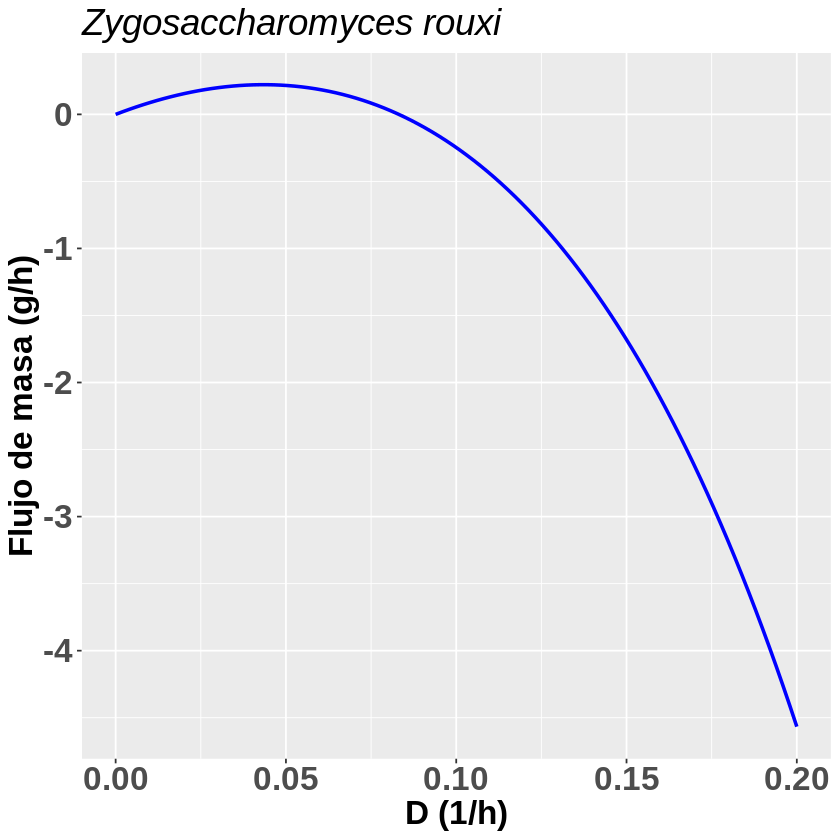

In [101]:
# mostrar resultados 
ggplot(out_zr, aes(x = D, y = Gain)) +
  geom_line(lty = 1, lwd = 1, color = "blue") +
  ylab("Flujo de masa (g/h)") +
  xlab("D (1/h)") +
  labs(title = "Zygosaccharomyces rouxi") +
  theme(
        plot.title = element_text(size=22, face = "italic"),
        axis.text=element_text(size=20, face = "bold"),
        axis.title=element_text(size=20,face="bold"),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

### Realizar optimización 

In [102]:
# encontrar el máximo
sol_zr <- optimise(f = gain2, lower = 0,upper = 0.08,p = p_zr)
# solución analítica
cat("D_opt de forma analítica:", D_opt(p_zr), "(1/h) \n")
# solución numérica
cat("D_opt:", sol_zr$minimum, "(1/h) \n")
cat("mx_max: ", - sol_zr$objective, "g/h")

D_opt de forma analítica: 0.04985475 (1/h) 
D_opt: 0.04345595 (1/h) 
mx_max:  0.2215168 g/h

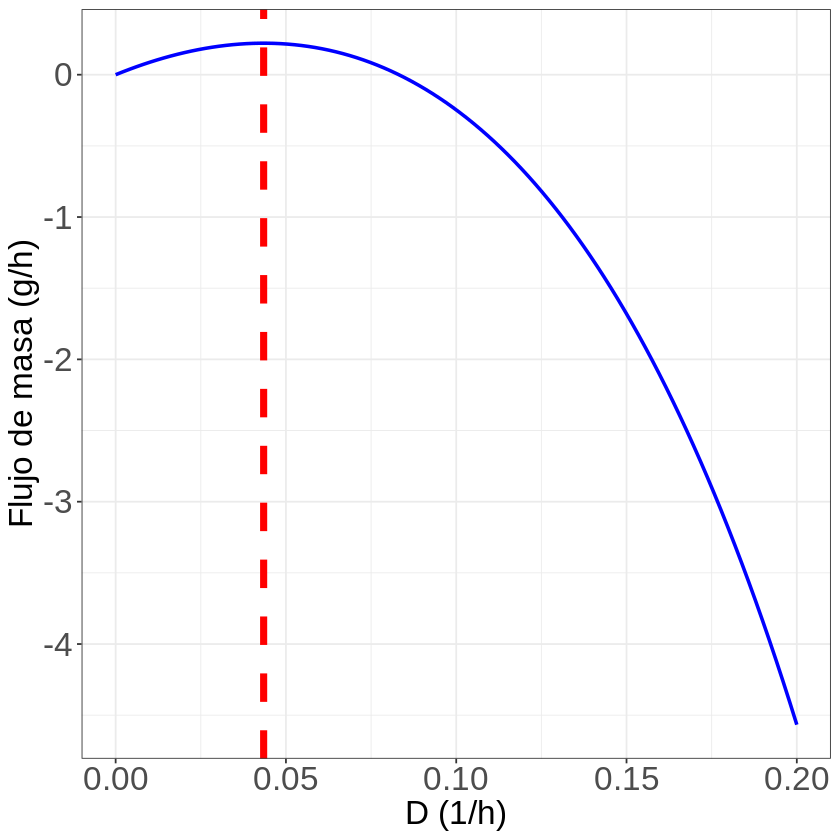

In [103]:
# mostrar resultados 
ggplot(out_zr, aes(x = D, y = Gain)) +
  geom_line(lty = 1, lwd = 1, color = "blue") +
  geom_vline(xintercept = sol_zr$minimum, color = "red", lty = 2, lwd = 2) +
  ylab("Flujo de masa (g/h)") +
  xlab("D (1/h)") +
  #labs(title = "Zygosaccharomyces rouxi") +
  theme_bw() +
  theme(
        plot.title = element_text(size=22),
        axis.text=element_text(size=20),
        axis.title=element_text(size=20),
        legend.title = element_text(size=20), 
        legend.text = element_text(size=20))

# Resultados 

Tabla 1. Valores de $D_{opt}$ y $\dot{m}_x$obtenido para las diferentes levaduras 

| levadura | $D$ | $\dot{m}_x$ | $\dot{m}_p$ |
|:---:|:---:|:---:|:---:|
| Isstchenkia terrícola | $0.113\ h^{-1}$ | $0.321\ g/h$ | $2.261\ g/h$ |
| Kluyveromyces marxianus | $0.0762\ h^{-1}$ | $0.309\ g/h$ |$1.523\ g/h$ |
| Pichia kluyveri | $0.0407\ h^{-1}$ | $0.1085\ g/h$ |$0.4186\ g/h$ |
| Zygosaccharomyces bailii | $0.0866\ h^{-1}$ | $0.2634\ g/h$ |$1.2986\ g/h$ |
| Zigosaccharomyces rouxi |$0.04345\ h^{-1}$ | $0.2215\ g/h$ |$0.6988\ g/h$ |

In [104]:
#@title D óptimos 
cat("Isstchenkia terrícola \n")
cat("D_opt:", sol_it$minimum, "(1/h) \n\n")
cat("Kluyveromyces marxianus \n")
cat("D_opt:", sol_km$minimum, "(1/h) \n\n")
cat("Pichia kluyveri \n")
cat("D_opt:", sol_pk$minimum, "(1/h) \n\n")
cat("Zygosaccharomyces bailii \n")
cat("D_opt:", sol_zb$minimum, "(1/h) \n\n")
cat("{Zigosaccharomyces rouxi \n")
cat("D_opt:", sol_zr$minimum, "(1/h)")

Isstchenkia terrícola 
D_opt: 0.1130833 (1/h) 

Kluyveromyces marxianus 
D_opt: 0.07625919 (1/h) 

Pichia kluyveri 
D_opt: 0.04077689 (1/h) 

Zygosaccharomyces bailii 
D_opt: 0.08664013 (1/h) 

{Zigosaccharomyces rouxi 
D_opt: 0.04345595 (1/h)

In [105]:
#@title mx máximo 
cat("Isstchenkia terrícola \n")
cat("mx_max: ", - sol_it$objective, "g/h \n\n")
cat("Kluyveromyces marxianus \n")
cat("mx_max: ", - sol_km$objective, "g/h \n\n")
cat("Pichia kluyveri \n")
cat("mx_max: ", - sol_pk$objective, "g/h \n\n")
cat("Zygosaccharomyces bailii \n")
cat("mx_max: ", - sol_zb$objective, "g/h \n\n")
cat("Zigosaccharomyces rouxi \n")
cat("mx_max: ", - sol_zr$objective, "g/h")

Isstchenkia terrícola 
mx_max:  0.3211742 g/h 

Kluyveromyces marxianus 
mx_max:  0.3094659 g/h 

Pichia kluyveri 
mx_max:  0.1085683 g/h 

Zygosaccharomyces bailii 
mx_max:  0.2634087 g/h 

Zigosaccharomyces rouxi 
mx_max:  0.2215168 g/h

In [106]:
Gain2 <- function(Ypx, Gain1) {

    gain = Ypx* Gain1

    return(gain)
}

In [107]:
#@title mp máximo 
cat("Isstchenkia terrícola \n")
cat("mp_max: ",Gain2(7.041,- sol_it$objective), "g/h \n\n")
cat("Kluyveromyces marxianus \n")
cat("mp_max: ", Gain2(4.944,- sol_km$objective), "g/h \n\n")
cat("Pichia kluyveri \n")
cat("mp_max: ", Gain2(3.865,- sol_pk$objective), "g/h \n\n")
cat("Zygosaccharomyces bailii \n")
cat("mp_max: ", Gain2(4.930,- sol_zb$objective), "g/h \n\n")
cat("Zigosaccharomyces rouxi \n")
cat("mp_max: ", Gain2(3.155,- sol_zr$objective), "g/h")

Isstchenkia terrícola 
mp_max:  2.261388 g/h 

Kluyveromyces marxianus 
mp_max:  1.529999 g/h 

Pichia kluyveri 
mp_max:  0.4196165 g/h 

Zygosaccharomyces bailii 
mp_max:  1.298605 g/h 

Zigosaccharomyces rouxi 
mp_max:  0.6988854 g/h

### Gráfica de barras con tasas de dilución óptimas 

In [108]:
data <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    D_opt = c(D_opt(p_it),D_opt(p_km),D_opt(p_pk),D_opt(p_zb),D_opt(p_zr)))

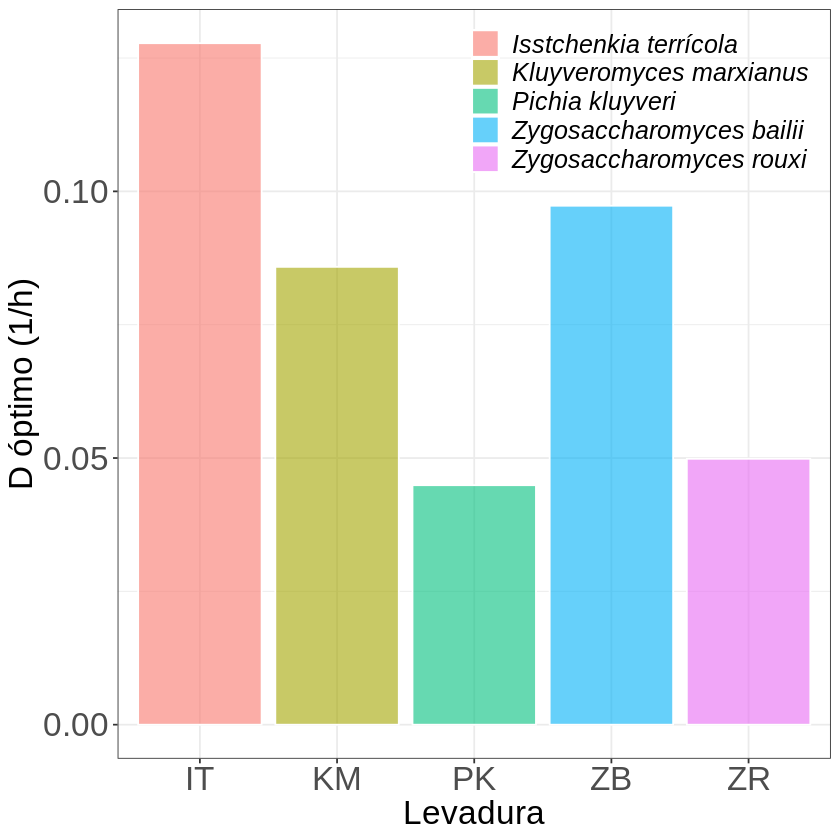

In [109]:
ggplot(data=data, aes(x=lev, y=D_opt, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("D óptimo (1/h)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.90), 
            legend.background = element_rect(fill=NA))
            

In [110]:
tasas <- data.frame(D = rep(out_it$D, 5), lev = rep(c("IT","KM","PK","ZB","ZR"), each = length(out_it$D)), 
                    gain = c(out_it$Gain,out_km$Gain,out_pk$Gain,out_zb$Gain,out_zr$Gain))
write.csv(tasas, "tasas.csv", row.names = F)

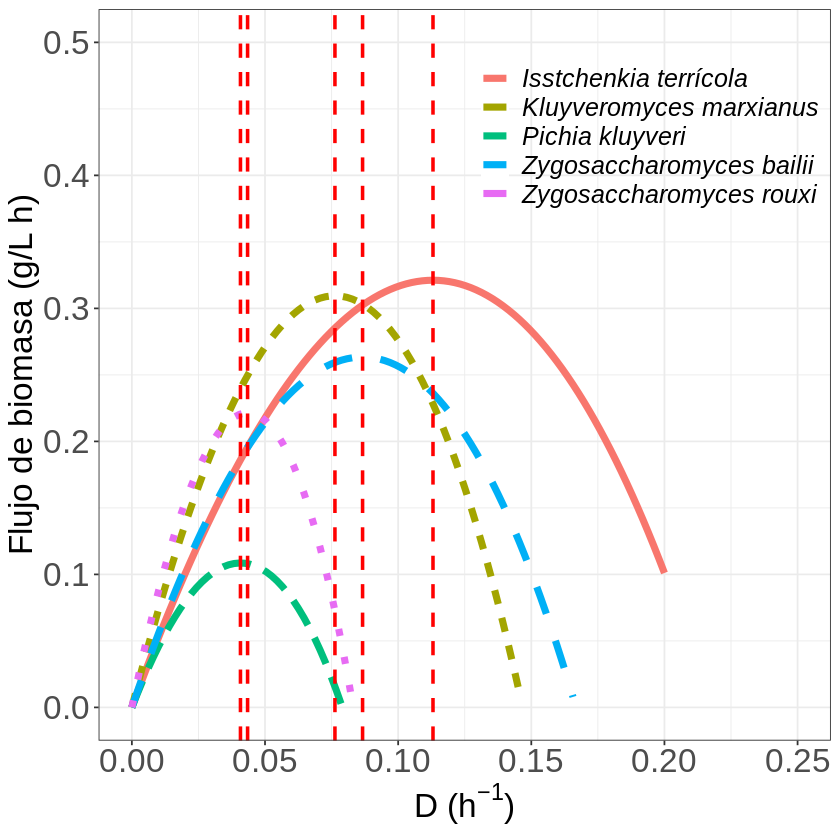

In [119]:
# mostrar resultados 
ggplot(data = tasas, aes(x = D, y = gain, group = lev)) +
  geom_line(aes(linetype = lev, color = lev), lwd = 2) +
  geom_vline(xintercept = sol_it$minimum, color = "red", size = 1, lty = 2) +
  geom_vline(xintercept = sol_km$minimum, color = "red", size = 1, lty = 2) +
  geom_vline(xintercept = sol_pk$minimum, color = "red", size = 1, lty = 2) +
  geom_vline(xintercept = sol_zb$minimum, color = "red", size = 1, lty = 2) +
  geom_vline(xintercept = sol_zr$minimum, color = "red", size = 1, lty = 2) +
  #geom_point(x = sol_it$minimum, y =  - sol_it$objective, color = "red", size = 5) +
  ylab("Flujo de biomasa (g/L h)") +
  xlab(expression("D ("*h^-1*")")) +
  xlim(c(0,0.25))+
  ylim(c(0,0.5)) +
  scale_linetype_discrete(name = "", c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  scale_color_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic"),
            legend.position = c(0.75,0.85), 
            legend.background = element_rect(fill=NA))

In [112]:
options(warn =  -1)

### Gráfica de barras para la producción de biomasa 

In [113]:
data_mx <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    mx = c(-sol_it$objective,-sol_km$objective,-sol_pk$objective,-sol_zb$objective,-sol_zr$objective))

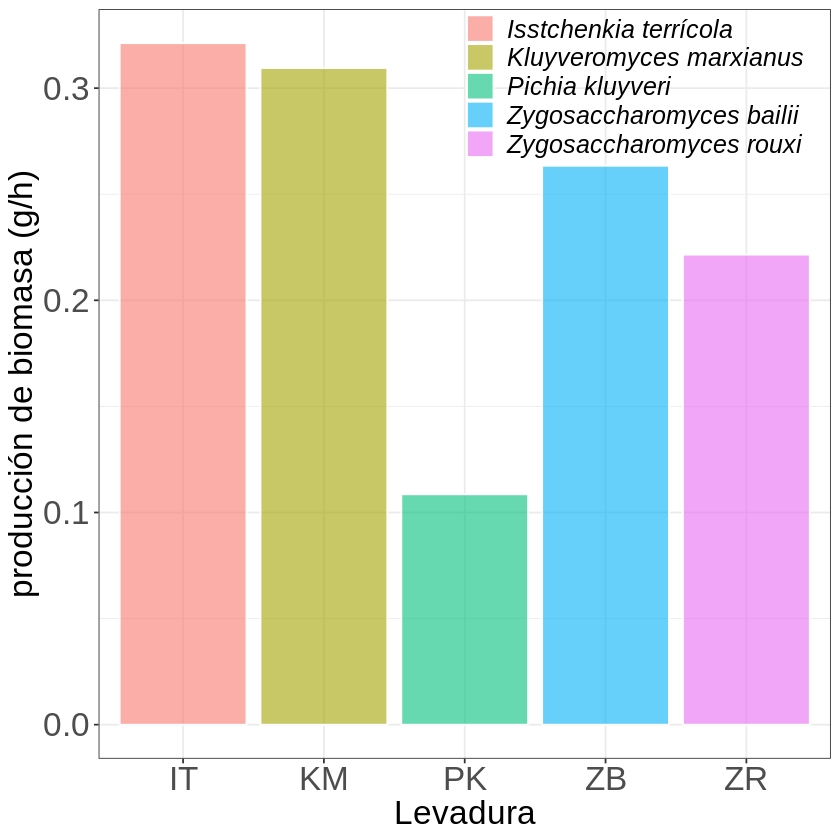

In [114]:
ggplot(data=data_mx, aes(x=lev, y=mx, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("producción de biomasa (g/h)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.92), 
            legend.background = element_rect(fill=NA))
            

### Gráfica de barras para la producción de etanol

In [115]:
data_mp <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    mx = c(Gain2(7.041,- sol_it$objective),Gain2(4.944,- sol_km$objective),
                    Gain2(3.865,- sol_pk$objective),Gain2(4.930,- sol_zb$objective),
                    Gain2(3.155,- sol_zr$objective)))

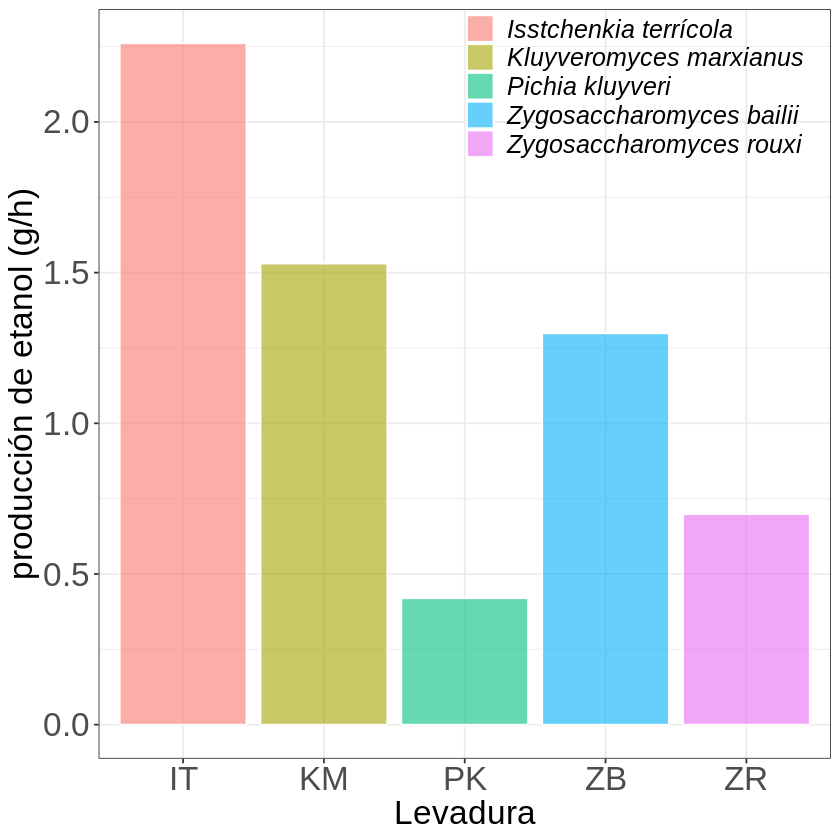

In [116]:
ggplot(data=data_mp, aes(x=lev, y=mx, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("producción de etanol (g/h)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.92), 
            legend.background = element_rect(fill=NA))
            